Example of how to use codebase to analyse importance of weights in CNN model zoo

In [1]:
# imports
import torch as th
import numpy as np
import matplotlib.pyplot as plt

# Load Data
We load data from Unterthiner's small CNN model zoo. The metrics are enriched with per class accuracy for every model.

In [2]:
from utils.load_dataset import load_dataset
dataset = 'fashion_mnist'
train, test, val = load_dataset(dataset, metrics_file='metrics_merged.csv', load_class_acc=True)
weights_train, outputs_train, configs_train = train
# Using validation set for test metrics in this example
weights_test, outputs_test, configs_test = val
train_class_accuracies = outputs_train[:, -10:]
test_class_accuracies = outputs_test[:, -10:]

# Get probe/lens model
We train an MLP regressor model to predict per class accuracy. If the regressor is of sufficiently good quality, i.e. it predicts class accuracy with a small enough MSE, we might learn what weights are important for predicitng per class accuracy from studying this probe/lens.

In [3]:
from lenses.regressor_lens import get_regressor_lens
regressor_lens = get_regressor_lens(weights_train, train_class_accuracies, weights_test, test_class_accuracies)

Epoch   1 ─ val MSE 0.031104 | val MAE 0.111499
Epoch   2 ─ val MSE 0.019994 | val MAE 0.080003
Epoch   3 ─ val MSE 0.019361 | val MAE 0.078551
Epoch   4 ─ val MSE 0.018184 | val MAE 0.073528
Epoch   5 ─ val MSE 0.017484 | val MAE 0.070826
Epoch   6 ─ val MSE 0.017624 | val MAE 0.071880
Epoch   7 ─ val MSE 0.018498 | val MAE 0.075788
Epoch   8 ─ val MSE 0.017201 | val MAE 0.068402
Epoch   9 ─ val MSE 0.017553 | val MAE 0.073198
Epoch  10 ─ val MSE 0.017268 | val MAE 0.069474
Epoch  11 ─ val MSE 0.017545 | val MAE 0.069946
Epoch  12 ─ val MSE 0.017638 | val MAE 0.069861
Epoch  13 ─ val MSE 0.018556 | val MAE 0.071559
Epoch  14 ─ val MSE 0.017159 | val MAE 0.069834
Epoch  15 ─ val MSE 0.016799 | val MAE 0.068358
Epoch  16 ─ val MSE 0.018025 | val MAE 0.072963
Epoch  17 ─ val MSE 0.016571 | val MAE 0.066739
Epoch  18 ─ val MSE 0.017055 | val MAE 0.067467
Epoch  19 ─ val MSE 0.018339 | val MAE 0.070861
Epoch  20 ─ val MSE 0.017804 | val MAE 0.069244
Epoch  21 ─ val MSE 0.016933 | val MAE 0

Our regressor lens can make predictions on class accuracy

CNN model index: 16
Label class accuracy for CNN model 16: [0.82  0.95  0.736 0.823 0.746 0.921 0.542 0.932 0.944 0.938]
Predicted class accuracy: [0.78487664 0.9448599  0.7764843  0.8376669  0.7329548  0.9118149
 0.47561607 0.9065053  0.9426095  0.9455174 ]


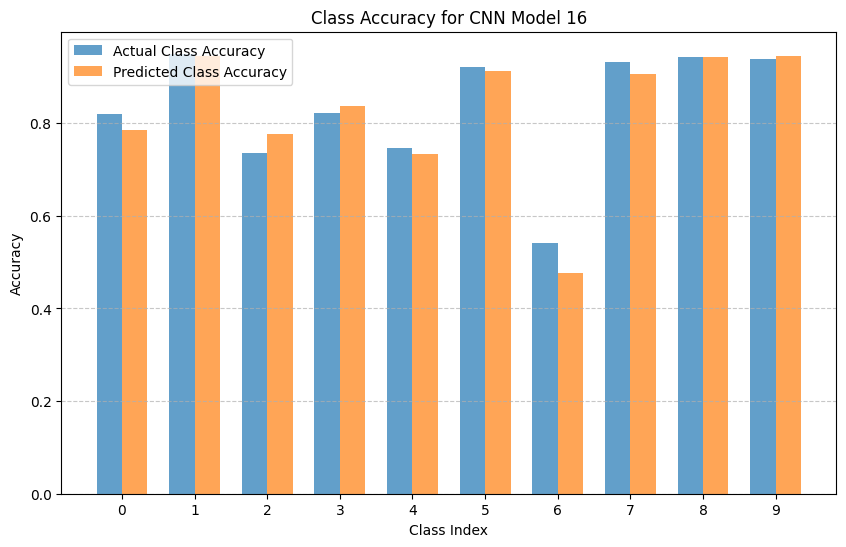

In [4]:
# Define the CNN model index and retrieve its weights and class accuracy
CNN_index = 16  # Example index of a CNN model in the dataset
CNN_weights = weights_train[CNN_index]
CNN_class_accuracy = train_class_accuracies[CNN_index]

# Print model details
print(f"CNN model index: {CNN_index}")
print(f"Label class accuracy for CNN model {CNN_index}: {CNN_class_accuracy}")

# Predict class accuracy using the regressor lens
predicted_class_accuracy = regressor_lens.forward(
    th.tensor(CNN_weights, dtype=th.float32).unsqueeze(0)
).detach().numpy().flatten()
print(f"Predicted class accuracy: {predicted_class_accuracy}")

# Plot the predicted and actual class accuracies as a bar plot
plt.figure(figsize=(10, 6))
width = 0.35  # Width of the bars
x = np.arange(len(CNN_class_accuracy))  # Class indices

# Plot actual class accuracy
plt.bar(x - width / 2, CNN_class_accuracy, width, label="Actual Class Accuracy", alpha=0.7)

# Plot predicted class accuracy
plt.bar(x + width / 2, predicted_class_accuracy, width, label="Predicted Class Accuracy", alpha=0.7)

# Add plot details
plt.title(f"Class Accuracy for CNN Model {CNN_index}")
plt.xlabel("Class Index")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Attribution analysis
By studying the regressor lens, we might learn which CNN weights are important for the regressor to make it's predicition. Let's try an attribution method; Integrated Gradients

In [5]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(regressor_lens)

attributions = {}  # attributions for each class

for class_idx in range(10):
    attributions[class_idx] = ig.attribute(
        th.tensor(CNN_weights, dtype=th.float32).unsqueeze(0),
        target=class_idx,
).flatten().detach().numpy()

/Users/ilic/Documents/CWI/Explainability and Interpretability/WeightSpaceClassifier/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's plot the results (zoom in and scroll around)

In [6]:
import plotly.graph_objects as go

# Create a grouped bar chart
fig = go.Figure()

for class_idx, class_attributions in attributions.items():
    mean_attributions = class_attributions
    fig.add_trace(go.Bar(
        x=list(range(len(mean_attributions))),
        y=mean_attributions,
        name=f'Class {class_idx}',
        width=0.9,
        opacity=0.7,
    ))

# Add layout details
fig.update_layout(
    title=f'Attributions Across input CNN weights for predicting accuracy for Each Class for {dataset} CNN Model {CNN_index}',
    xaxis_title='Feature Index (Weight Index)',
    yaxis_title='Attribution Value',
    barmode='overlay',  # Align bars for each dataset
    legend_title='Classes'
)

fig.show()